# CENTRALITY IS ALL YOU NEED
## LFN Project

### Description of the project
- **Aim**: try to detect the most influential political figures and their political party.

## Load libraries

In [42]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

## Loading of the graph and calculation of some metrics

In [43]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [44]:
nodes

,id,name,new_id
0,127397457601670,陳根德,1661
1,169014523134260,林淑芬,52
2,295363753921281,Chris White,3477
3,613631835423903,Stewart Hosie MP,3193
4,284882801581896,Frank Schäffler,4425
...,...,...,...
5903,342943772496246,Kevin Byrne,3778
5904,193944157325672,Timur Husein,439
5905,142026376065,Jeremy Lefroy,159
5906,294019144024664,Ileana Argentin,107


In [45]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [46]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [47]:
G.is_directed()

False

In [48]:
nkG = nk.nxadapter.nx2nk(G)

In [49]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [50]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [51]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [52]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [53]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

5.532339993227226

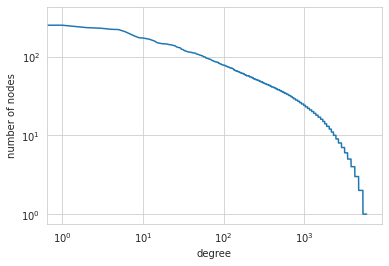

In [54]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [55]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.021061182022094727 [s]
solution properties:
-------------------  ----------
# communities         28
min community size    18
max community size   542
avg. community size  210.929
modularity             0.866605
-------------------  ----------


0.8666053420477957

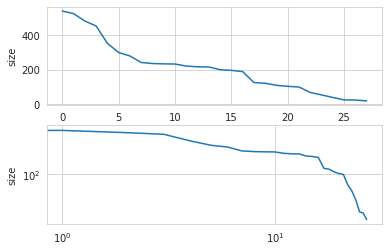

In [56]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality

In [57]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(G,100, epsilon=0.05, normalized=True).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G,epsilon=0.05).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [58]:
#centrality(G,"closeness","nx")

In [59]:
cc = centrality(nkG,"closeness","nk")

--- 0.49013280868530273 seconds ---


In [60]:
top10cc = dict(cc[:10])
keys10cc = list(top10cc.keys())
values10cc = list(top10cc.values())
nodesTop10cc = nodes[nodes["new_id"].isin(keys10cc)]
nodesTop10cc["cc"] = values10cc
nodesTop10cc

<ipython-input-60-eeca2ecd9c7e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10cc["cc"] = values10cc


,id,name,new_id,cc
385,425788730806692,Pierre Moreau,810,0.358857
1552,1008920055906510,Monika Lazar,219,0.323508
2228,1457854404494601,Hervé Gaymard,233,0.320471
2611,728842613851000,Margaret Quirk MLA,157,0.317422
4205,169196224815,Giovanni Capriglione,50,0.312467
4358,168468263243635,Sylviane Bulteau,703,0.310855
4900,449533531817208,Alejandra Morlan,228,0.309697
5193,336733203010225,Assemblyman Ray Walter,853,0.307536
5227,384662044972285,"Norbert Spinrath, MdB",941,0.305547
5327,232363686957754,Alexander Kulitz,855,0.305152


In [61]:
#centrality(G,"betweenness","nx")

In [62]:
bc = centrality(nkG,"betweenness","nk")

--- 4.619564533233643 seconds ---


In [63]:
top10bc = dict(bc[:10])
keys10bc = list(top10bc.keys())
values10bc = list(top10bc.values())
nodesTop10bc = nodes[nodes["new_id"].isin(keys10bc)]
nodesTop10bc["bc"] = values10bc
nodesTop10bc

<ipython-input-63-148da339cf7a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10bc["bc"] = values10bc


,id,name,new_id,bc
385,425788730806692,Pierre Moreau,810,0.536616
592,397307097023253,Justine Elliot MP,140,0.111042
2490,229547190392110,"Laurin Liu, Candidate NPD, RDMI",951,0.108292
2611,728842613851000,Margaret Quirk MLA,157,0.096549
2972,662955787059972,Shane King MP- Labor for Kurwongbah,138,0.090176
2981,326547101058452,Reinhard Brandl,255,0.074552
3194,148900938515423,Sofie Carsten Nielsen,177,0.070736
3237,9094598058,Leopoldo Lopez,638,0.068160
4205,169196224815,Giovanni Capriglione,50,0.063586
4358,168468263243635,Sylviane Bulteau,703,0.057986


In [64]:
acc = centrality(nkG,"approxclose","nk")

--- 0.055086374282836914 seconds ---


In [65]:
top10acc = dict(acc[:10])
keys10acc = list(top10acc.keys())
values10acc = list(top10acc.values())
nodesTop10acc = nodes[nodes["new_id"].isin(keys10acc)]
nodesTop10acc["acc"] = values10acc
nodesTop10acc

<ipython-input-65-155343c7ba8d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10acc["acc"] = values10acc


,id,name,new_id,acc
682,568839896564552,Marie-Claude Bibeau,147,0.384615
1552,1008920055906510,Monika Lazar,219,0.331126
2228,1457854404494601,Hervé Gaymard,233,0.330033
4205,169196224815,Giovanni Capriglione,50,0.326797
4358,168468263243635,Sylviane Bulteau,703,0.324675
4900,449533531817208,Alejandra Morlan,228,0.320471
5193,336733203010225,Assemblyman Ray Walter,853,0.318471
5227,384662044972285,"Norbert Spinrath, MdB",941,0.315457
5327,232363686957754,Alexander Kulitz,855,0.314465
5492,150237258650302,Cynthia Viteri,857,0.314465


In [66]:
abc = centrality(nkG,"approxbet","nk")

--- 0.991788387298584 seconds ---


In [67]:
top10abc = dict(abc[:10])
keys10abc = list(top10abc.keys())
values10abc = list(top10abc.values())
nodesTop10abc = nodes[nodes["new_id"].isin(keys10abc)]
nodesTop10abc["abc"] = values10abc
nodesTop10abc

<ipython-input-67-8006ea99b19e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10abc["abc"] = values10abc


,id,name,new_id,abc
385,425788730806692,Pierre Moreau,810,0.277207
592,397307097023253,Justine Elliot MP,140,0.057495
2490,229547190392110,"Laurin Liu, Candidate NPD, RDMI",951,0.053388
2611,728842613851000,Margaret Quirk MLA,157,0.047570
2663,342928465888942,Alain Leboeuf,308,0.045517
2972,662955787059972,Shane King MP- Labor for Kurwongbah,138,0.035934
2981,326547101058452,Reinhard Brandl,255,0.035250
3194,148900938515423,Sofie Carsten Nielsen,177,0.033539
4205,169196224815,Giovanni Capriglione,50,0.028747
4358,168468263243635,Sylviane Bulteau,703,0.028063


In [68]:
#visualize a subgraph
#H = G.subgraph(list(G.nodes)[:100])
#nt = Network('900px','1820px')
#nt.from_nx(H)
#nt.show('nx.html')

## Global and local clustering coefficient

In [69]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.4299053244158777

In [70]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [71]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [72]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [73]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs

In [74]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3486154


In [75]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 899684


In [76]:
#Chung-Lu model
degreeSequence = [CRG.degree(v) for v in CRG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
#nk.community.detectCommunities(CLG)

5906 900417


In [77]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            degreeSequence = param
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values

In [78]:
# Generate random graphs
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G'
#    f: float

def pvalues(FG,f):
    plarger = sum(map(lambda x : x>= f, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= f, FG))/len(FG)
    return plarger,psmaller



In [79]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]

In [80]:
def generateDataFrame(G, alg, nrGraphs, algRnd):
    if algRnd == "ER":
        RndGraphs = generateRandGraphs("ER", nrGraphs, [G.numberOfNodes(), 0.0025])
    if algRnd == "CL":
        degreeSequence = [G.degree(v) for v in G.iterNodes()]
        RndGraphs = generateRandGraphs("CL", nrGraphs, degreeSequence)
        
    if alg == "CC":
        RndFeatures = list(map(nk.centrality.Closeness,RndGraphs,[True for i in range(nrGraphs)],[False for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"closeness","nk"))
    if alg == "BC":
        RndFeatures = list(map(nk.centrality.Betweenness,RndGraphs,[True for i in range(nrGraphs)],[False for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"betweenness","nk"))
    if alg == "approxCC":
        RndFeatures = list(map(nk.centrality.ApproxCloseness,RndGraphs,[100 for i in range(nrGraphs)],[0.05 for i in range(nrGraphs)],[True for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxclose","nk"))
    if alg == "approxBC":
        RndFeatures = list(map(nk.centrality.ApproxBetweenness,RndGraphs,[0.05 for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxbet","nk"))
            
    RndFeaturesRanking = list(map(lambda obj: obj.ranking(), RndFeatures))
    # merge RndFeaturesRanking, we will obtain a list of (key,value) pairs 
    #representing the id of each node as key
    # and the closeness centrality as value
    RndFeaturesRankingMerged = list(itertools.chain(*RndFeaturesRanking))
    RndFeaturesRanking_df = pd.DataFrame(RndFeaturesRankingMerged)
    RndFeaturesRanking_df.columns = {"key":"key", "centrality":"value"}

    mean_by_key = RndFeaturesRanking_df.groupby("key").mean()
    std_by_key = RndFeaturesRanking_df.groupby("key").std()

    f.columns = {"key":"key","centrality":"value"}
    f = f.set_index('key').sort_index()

    zscore_closeness = pd.DataFrame(zscore(f["centrality"],mean_by_key["centrality"],std_by_key["centrality"]))
    zscore_closeness.columns = {"zscore"}
    zscore_closeness["centrality_f"] = f["centrality"]
    zscore_closeness["mean_rand"] = mean_by_key
    zscore_closeness["std_rand"] = std_by_key
    return zscore_closeness

In [81]:
df_test_BC = generateDataFrame(nkG, "BC", 10, "ER")
df_test_CC = generateDataFrame(nkG, "CC", 10, "ER")
df_test_approxCC = generateDataFrame(nkG, "approxCC", 10, "ER")
df_test_approxBC = generateDataFrame(nkG, "approxBC", 10, "ER")

10it [01:01,  6.12s/it]
0it [00:00, ?it/s]

--- 4.869725465774536 seconds ---


10it [00:05,  1.80it/s]
2it [00:00, 18.97it/s]

--- 0.48528504371643066 seconds ---


10it [00:00, 19.43it/s]
0it [00:00, ?it/s]

--- 0.0486903190612793 seconds ---


10it [00:11,  1.16s/it]


--- 1.0068330764770508 seconds ---


In [82]:
df_test_BC_CL = generateDataFrame(nkG, "BC", 10, "CL")
df_test_CC_CL = generateDataFrame(nkG, "CC", 10, "CL")
df_test_approxCC_CL = generateDataFrame(nkG, "approxCC", 10, "CL")
df_test_approxBC_CL = generateDataFrame(nkG, "approxBC", 10, "CL")

10it [00:49,  4.99s/it]


--- 4.579207420349121 seconds ---


RuntimeError: Error: the standard definition of closeness is not defined on disconnected graphs. On disconnected graphs, use the generalized definition instead.

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.tight_layout(h_pad=3)
axis[0,0].hist(df_test_CC['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC['zscore'], density=True, bins=50)
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC['zscore'], density=True, bins=50)
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

In [ ]:
bins=7
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC['centrality_f'], bins), y='zscore', data=df_test_CC, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC['centrality_f'], bins), y='zscore', data=df_test_BC, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC['centrality_f'], bins), y='zscore', data=df_test_approxCC, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC['centrality_f'], bins), y='zscore', data=df_test_approxBC, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

In [ ]:
ER_graphs[0].numberOfEdges(),ER_graphs[0].numberOfNodes(),ER_graphs[0].numberOfSelfLoops()

In [ ]:
nkG.numberOfEdges(),nkG.numberOfNodes(),nkG.numberOfSelfLoops()

In [ ]:
avg_CC_randG = list(map(nk.globals.clustering, ER_graphs))
zscore_randG = zscore(ACC_nkG,np.mean(avg_CC_randG), np.std(avg_CC_randG))
print(zscore_randG)

In [ ]:
plarger_, psmaller_ = pvalues(avg_CC_randG, 0.99)
plarger_, psmaller_

In [ ]:
avg_CC_randG